[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial3.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 3: Reconstructing Past Changes in Terrestrial Climate**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Dionessa Biton, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google DeepMind

# **Tutorial Objectives**

In this tutorial, we’ll explore the Euro2K proxy network, which is a subset of PAGES2K, the database we explored in the first tutorial. We will specifically focus on interpreting temperature change over the past 2,000 years as recorded by proxy records from tree rings, speleothems, and lake sediments. To analyze these datasets, we will group them by archive and create time series plots to assess temperature variations.

During this tutorial you will:

*   Plot temperature records based on three different terrestrial proxies
*   Assess similarities and differences between the temperature records






# Setup

In [1]:
# imports
import pyleoclim as pyleo
import pandas as pd
import numpy as np
import os
import pooch
import tempfile
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [3]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W1D4_Paleoclimate' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# Section 1: Loading Terrestrial Paleoclimate Records

First, we need to download the data. Similar to Tutorial 1, the data is stored as a LiPD file, and we will be using Pyleoclim to format and interpret the data.

In [4]:
# set the name to save the Euro2k data
fname = "euro2k_data"

# download the data
lipd_file_path = pooch.retrieve(
    url="https://osf.io/7ezp3/download/",
    known_hash=None,
    path="./",
    fname=fname,
    processor=pooch.Unzip()
)

In [5]:
# the LiPD object can be used to load datasets stored in the LiPD format.
# in this first case study, we will load an entire library of LiPD files:
d_euro = pyleo.Lipd(os.path.join(".", f"{fname}.unzip", "Euro2k"))

/tmp/ipykernel_1114/1283218.py:3: DeprecationWarning: The Lipd class is being deprecated and will be removed in Pyleoclim v1.0.0. Functionalities will instead be handled by the pyLipd package.
  d_euro = pyleo.Lipd(os.path.join(".", f"{fname}.unzip", "Euro2k"))


Disclaimer: LiPD files may be updated and modified to adhere to standards

Found: 31 LiPD file(s)
reading: Ocn-AqabaJordanAQ19.Heiss.1999.lpd
reading: Eur-FinnishLakelands.Helama.2014.lpd
reading: Arc-Tornetrask.Melvin.2012.lpd
reading: Ocn-RedSea.Felis.2000.lpd
reading: Eur-SpannagelCave.Mangini.2005.lpd
reading: Eur-TatraMountains.Bntgen.2013.lpd
reading: Eur-RAPiD-17-5P.Moffa-Sanchez.2014.lpd
reading: Arc-Tjeggelvas.Bjorklund.2012.lpd
reading: Ocn-AqabaJordanAQ18.Heiss.1999.lpd
reading: Eur-Seebergsee.Larocque-Tobler.2012.lpd
reading: Eur-Stockholm.Leijonhufvud.2009.lpd
reading: Eur-CentralandEasternPyrenees.Pla.2004.lpd
reading: Arc-Indigirka.Hughes.1999.lpd
reading: Eur-NorthernScandinavia.Esper.2012.lpd
reading: Eur-EuropeanAlps.Bntgen.2011.lpd
reading: Arc-Forfjorddalen.McCarroll.2013.lpd
reading: Eur-NorthernSpain.Martn-Chivelet.2011.lpd
reading: Arc-Jamtland.Wilson.2016.lpd
reading: Eur-EasternCarpathianMountains.Popa.2008.lpd
reading: Arc-GulfofAlaska.Wilson.2014.lpd
reading:

# Section 2: Temperature Reconstructions

Before plotting, let's narrow the data down a bit. We can filter all of the data so that we only keep reconstructions of temperature from terrestrial archives (e.g. tree rings, speleothems and lake sediments). This is accomplished with the function below.

In [6]:
def filter_data(dataset, archive_type, variable_name):
    """
    Return a MultipleSeries object with the variable record (variable_name) for a given archive_type and coordinates.
    """
    # Create a list of dictionary that can be iterated upon using Lipd.to_tso method
    ts_list = dataset.to_tso()
    # Append the correct indices for a given value of archive_type and variable_name
    indices = []
    lat = []
    lon = []
    for idx, item in enumerate(ts_list):
        # Check that it is available to avoid errors on the loop
        if 'archiveType' in item.keys():
            # If it's a archive_type, then proceed to the next step
            if item['archiveType'] == archive_type:
                if item['paleoData_variableName'] == variable_name:
                    indices.append(idx)
    print(indices)
    # Create a list of LipdSeries for the given indices
    ts_list_archive_type = []
    for indice in indices:
        ts_list_archive_type.append(pyleo.LipdSeries(ts_list[indice]))

        # save lat and lons of proxies
        lat.append(ts_list[indice]['geo_meanLat'])
        lon.append(ts_list[indice]['geo_meanLon'])

    return pyleo.MultipleSeries(ts_list_archive_type), lat, lon

In the function above, the [`Lipd.to_tso`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.lipd.Lipd.to_tso) method is used to obtain a list of dictionaries that can be iterated upon. 

In [7]:
ts_list = d_euro.to_tso()

extracting paleoData...
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-Tornetrask.Melvin.2012
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-SpannagelCave.Mangini.2005
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Arc-Tjeggelvas.Bjorklund.2012
extracting: Ocn-AqabaJordanAQ18.Heiss.1999
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Eur-CentralandEasternPyrenees.Pla.2004
extracting: Arc-Indigirka.Hughes.1999
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Eur-CentralEurope.Dobrovolný.2009
extracti

Dictionaries are native to Python and can be explored as shown below. 

In [8]:
# look at available entries for just one time-series
ts_list[0].keys()

dict_keys(['mode', 'time_id', '@context', 'archiveType', 'createdBy', 'dataContributor', 'dataSetName', 'googleDataURL', 'googleMetadataWorksheet', 'googleSpreadSheetKey', 'originalDataURL', 'studyName', 'tagMD5', 'pub1_author', 'pub1_citeKey', 'pub1_journal', 'pub1_pages', 'pub1_title', 'pub1_type', 'pub1_volume', 'pub1_year', 'pub1_doi', 'pub2_author', 'pub2_citeKey', 'pub2_dataUrl', 'pub2_issue', 'pub2_journal', 'pub2_pages', 'pub2_publisher', 'pub2_title', 'pub2_type', 'pub2_volume', 'pub2_year', 'pub2_doi', 'pub3_author', 'pub3_Urldate', 'pub3_citeKey', 'pub3_institution', 'pub3_title', 'pub3_type', 'pub3_url', 'geo_type', 'geo_meanLon', 'geo_meanLat', 'geo_meanElev', 'geo_ocean', 'geo_pages2kRegion', 'geo_siteName', 'lipdVersion', 'tableType', 'paleoData_paleoDataTableName', 'paleoData_paleoDataMD5', 'paleoData_googleWorkSheetKey', 'paleoData_measurementTableName', 'paleoData_measurementTableMD5', 'paleoData_filename', 'paleoData_tableName', 'paleoData_missingValue', 'year', 'yea

In [9]:
# print relevant information for all entries
for idx, item in enumerate(ts_list):
    print(str(idx)+': '+item['dataSetName']+': '+item['paleoData_variableName'])

0: Ocn-AqabaJordanAQ19.Heiss.1999: d18O
1: Ocn-AqabaJordanAQ19.Heiss.1999: year
2: Ocn-AqabaJordanAQ19.Heiss.1999: d13C
3: Eur-FinnishLakelands.Helama.2014: temperature
4: Eur-FinnishLakelands.Helama.2014: year
5: Arc-Tornetrask.Melvin.2012: temperature
6: Arc-Tornetrask.Melvin.2012: year
7: Arc-Tornetrask.Melvin.2012: temperature
8: Arc-Tornetrask.Melvin.2012: sampleDensity
9: Ocn-RedSea.Felis.2000: d18O
10: Ocn-RedSea.Felis.2000: year
11: Eur-SpannagelCave.Mangini.2005: d18O
12: Eur-SpannagelCave.Mangini.2005: year
13: Eur-TatraMountains.Büntgen.2013: trsgi
14: Eur-TatraMountains.Büntgen.2013: year
15: Eur-RAPiD-17-5P.Moffa-Sanchez.2014: d18O
16: Eur-RAPiD-17-5P.Moffa-Sanchez.2014: year
17: Arc-Tjeggelvas.Bjorklund.2012: density
18: Arc-Tjeggelvas.Bjorklund.2012: year
19: Ocn-AqabaJordanAQ18.Heiss.1999: d18O
20: Ocn-AqabaJordanAQ18.Heiss.1999: year
21: Ocn-AqabaJordanAQ18.Heiss.1999: d13C
22: Eur-Seebergsee.Larocque-Tobler.2012: temperature
23: Eur-Seebergsee.Larocque-Tobler.2012: ye

Now let's use our pre-defined function to create a new list that only has temperature reconstructions based on proxies from **lake sediments**:

In [10]:
ms_euro_lake,euro_lake_lat,euro_lake_lon = filter_data(d_euro, 'lake sediment', 'temperature')

extracting paleoData...
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-Tornetrask.Melvin.2012
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-SpannagelCave.Mangini.2005
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Arc-Tjeggelvas.Bjorklund.2012
extracting: Ocn-AqabaJordanAQ18.Heiss.1999
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Eur-CentralandEasternPyrenees.Pla.2004
extracting: Arc-Indigirka.Hughes.1999
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Eur-CentralEurope.Dobrovolný.2009
extracti

/tmp/ipykernel_1114/1759622019.py:22: DeprecationWarning: The LipdSeries class is being deprecated and will be removed in Pyleoclim v1.0.0. It will be replaced by the geoSeries class (currently in development).
  ts_list_archive_type.append(pyleo.LipdSeries(ts_list[indice]))


And a new list that only has temperature reconstructions based on proxies from **tree rings**:

In [11]:
ms_euro_tree,euro_tree_lat,euro_tree_lon = filter_data(d_euro, 'tree', 'temperature')

extracting paleoData...
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-Tornetrask.Melvin.2012
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-SpannagelCave.Mangini.2005
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Arc-Tjeggelvas.Bjorklund.2012
extracting: Ocn-AqabaJordanAQ18.Heiss.1999
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Eur-CentralandEasternPyrenees.Pla.2004
extracting: Arc-Indigirka.Hughes.1999
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Eur-CentralEurope.Dobrovolný.2009
extracti

/tmp/ipykernel_1114/1759622019.py:22: DeprecationWarning: The LipdSeries class is being deprecated and will be removed in Pyleoclim v1.0.0. It will be replaced by the geoSeries class (currently in development).
  ts_list_archive_type.append(pyleo.LipdSeries(ts_list[indice]))


And finally, a new list that only has temperature information based on proxies from **speleothems**:

In [12]:
ms_euro_spel,euro_spel_lat,euro_spel_lon = filter_data(d_euro, 'speleothem', 'd18O')

extracting paleoData...
extracting: Ocn-AqabaJordanAQ19.Heiss.1999
extracting: Eur-FinnishLakelands.Helama.2014
extracting: Arc-Tornetrask.Melvin.2012
extracting: Ocn-RedSea.Felis.2000
extracting: Eur-SpannagelCave.Mangini.2005
extracting: Eur-TatraMountains.Büntgen.2013
extracting: Eur-RAPiD-17-5P.Moffa-Sanchez.2014
extracting: Arc-Tjeggelvas.Bjorklund.2012
extracting: Ocn-AqabaJordanAQ18.Heiss.1999
extracting: Eur-Seebergsee.Larocque-Tobler.2012
extracting: Eur-Stockholm.Leijonhufvud.2009
extracting: Eur-CentralandEasternPyrenees.Pla.2004
extracting: Arc-Indigirka.Hughes.1999
extracting: Eur-NorthernScandinavia.Esper.2012
extracting: Eur-EuropeanAlps.Büntgen.2011
extracting: Arc-Forfjorddalen.McCarroll.2013
extracting: Eur-NorthernSpain.Martín-Chivelet.2011
extracting: Arc-Jamtland.Wilson.2016
extracting: Eur-EasternCarpathianMountains.Popa.2008
extracting: Arc-GulfofAlaska.Wilson.2014
extracting: Eur-LakeSilvaplana.Trachsel.2010
extracting: Eur-CentralEurope.Dobrovolný.2009
extracti

/tmp/ipykernel_1114/1759622019.py:22: DeprecationWarning: The LipdSeries class is being deprecated and will be removed in Pyleoclim v1.0.0. It will be replaced by the geoSeries class (currently in development).
  ts_list_archive_type.append(pyleo.LipdSeries(ts_list[indice]))


## Coding Exercises 2

Using the coordinate information output from the `filter_data()` function, make a plot of the locations of the proxies using the markers and colors from Tutorial 1. Note that data close together may not be very visible.

In [ ]:
# initate plot with the specific figure size
fig = plt.figure(figsize=(9,6))

# set base map projection
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()

# add land fratures using gray color
ax.add_feature(cfeature.LAND, facecolor='k')

# add coastlines
ax.add_feature(cfeature.COASTLINE)

# add the proxy locations
# Uncomment and complete following line
# ax.scatter(...,transform=ccrs.Geodetic(),label = ...,
#           s= 50, marker = 'd',color = [ 0.52734375, 0.8046875 , 0.97916667],edgecolor='k', zorder = 2)
# ax.scatter(...,transform=ccrs.Geodetic(),label = ...,
#           s= 50, marker = 'p',color = [ 0.73828125, 0.71484375, 0.41796875],edgecolor='k', zorder = 2)
# ax.scatter(...,transform=ccrs.Geodetic(),label = ...,
#           s= 50, marker = '8',color = [ 1, 0, 0],edgecolor='k', zorder = 2)

# change the map view to zoom in on central Pacific
ax.set_extent((0, 360, 0, 90), crs =ccrs.PlateCarree())

ax.legend(
    scatterpoints=1,
    bbox_to_anchor=(0, -0.4),
    loc='lower left',
    ncol=3,
    fontsize=15,
)

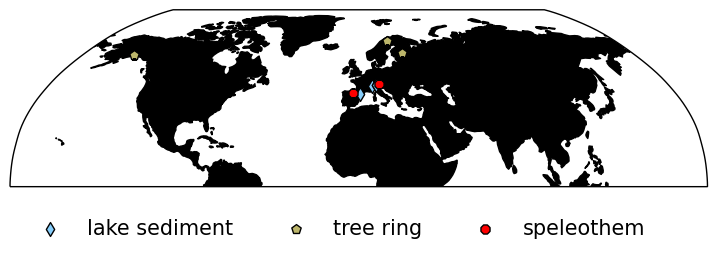

In [13]:
# to_remove solution

# initate plot with the specific figure size
fig = plt.figure(figsize=(9,6))

# set base map projection
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()

# add land fratures using gray color
ax.add_feature(cfeature.LAND, facecolor='k')

# add coastlines
ax.add_feature(cfeature.COASTLINE)

# add the proxy locations
# Uncomment and complete following line
ax.scatter(euro_lake_lon,euro_lake_lat,transform=ccrs.Geodetic(),label = 'lake sediment',
          s= 50, marker = 'd',color = [ 0.52734375, 0.8046875 , 0.97916667],edgecolor='k', zorder = 2)
ax.scatter(euro_tree_lon,euro_tree_lat,transform=ccrs.Geodetic(),label = 'tree ring',
          s= 50, marker = 'p',color = [ 0.73828125, 0.71484375, 0.41796875],edgecolor='k', zorder = 2)
ax.scatter(euro_spel_lon,euro_spel_lat,transform=ccrs.Geodetic(),label = 'speleothem',
          s= 50, marker = '8',color = [ 1, 0, 0],edgecolor='k', zorder = 2)

# change the map view to zoom in on central Pacific
ax.set_extent((0, 360, 0, 90), crs =ccrs.PlateCarree())

ax.legend(
    scatterpoints=1,
    bbox_to_anchor=(0, -0.4),
    loc='lower left',
    ncol=3,
    fontsize=15,
)

Since we are going to compare temperature datasets based on different terrestrial climate archives (lake sediments, tree rings and speleothems), the quantitative values of the measurements in each record will differ (i.e., the lake sediment and tree ring data are temperature in degrees C, but the speleothem data is oxygen isotopes in per mille). Therefore, to more easily and accurately compare temperature between the records, it's helpful to standardize the data as we did in tutorial 2. The `.standardize()` function removes the estimated mean of the time series and divides by its estimated standard deviation.

In [14]:
# standardize the data
spel_stnd = ms_euro_spel.standardize()
lake_stnd = ms_euro_lake.standardize()
tree_stnd = ms_euro_tree.standardize()

Now we can use Pyleoclim functions to create three stacked plots of this data with lake sediment records on top, tree ring reconstructions in the middle and speleothem records on the bottom. 


Note that the colors used for the time series in each plot are the default colors generated by the function, so the corresponding colors in each of the three plots are not relevant.

Text(0.5, 1.2, 'Speleothems')

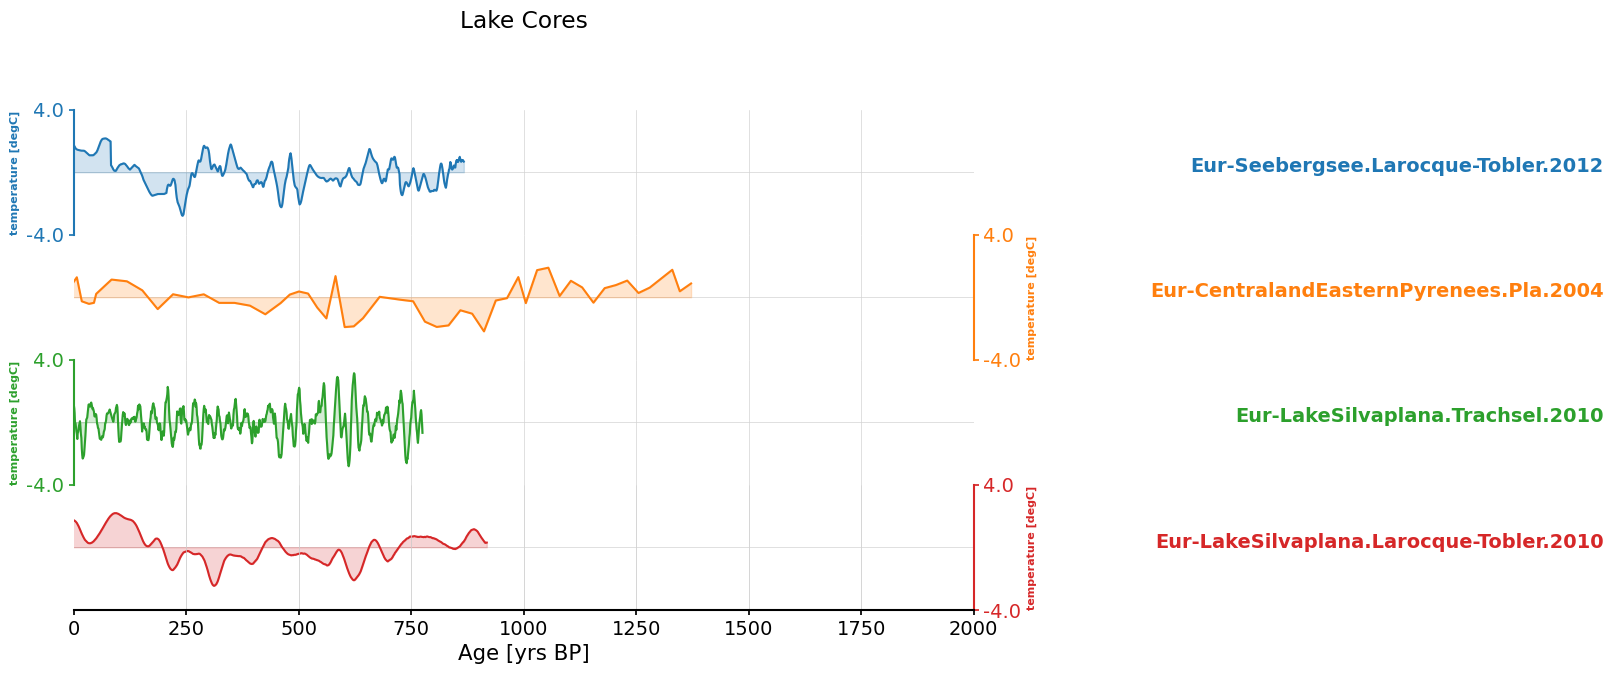

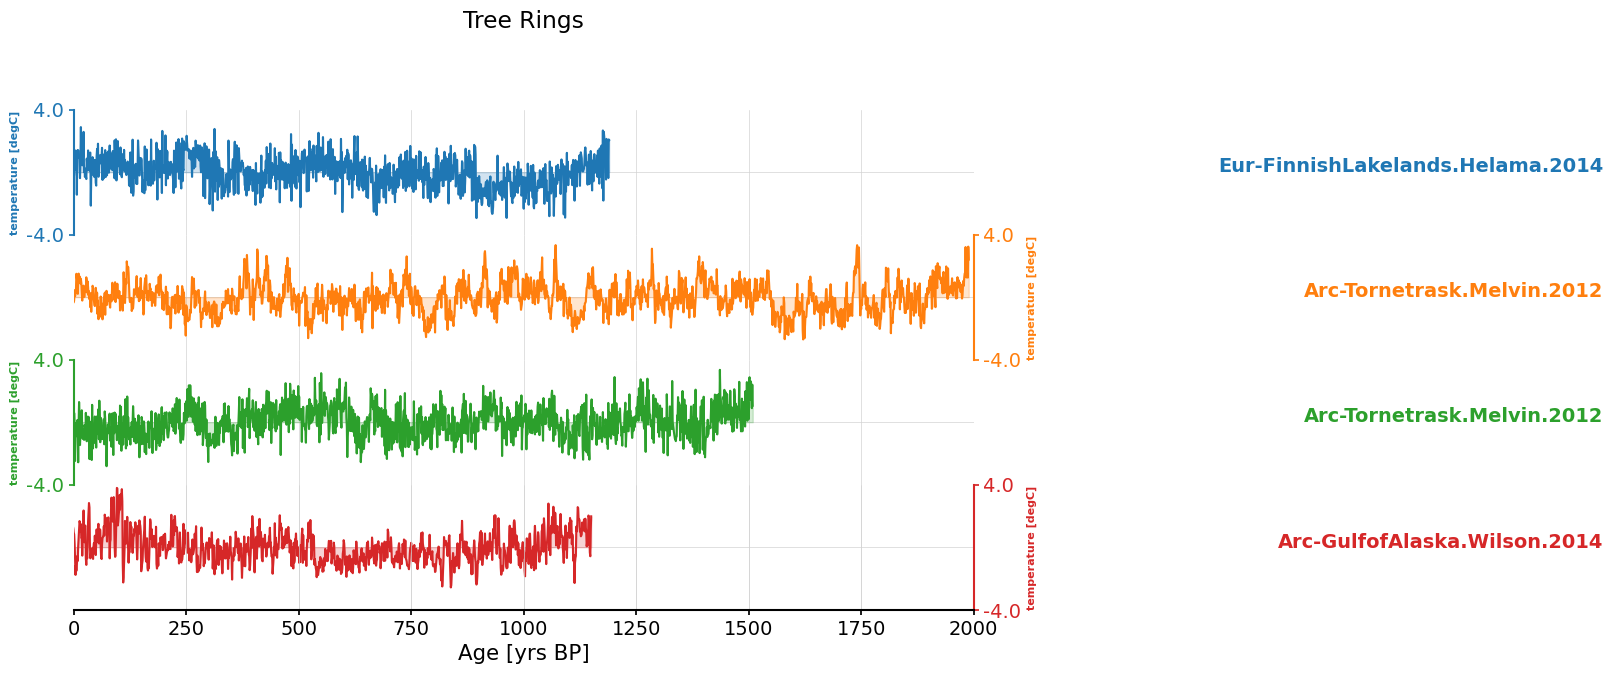

In [ ]:
# note the x axis is years before present, so read from left to right moving back in time

ax=lake_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5], time_unit="yrs BP")
ax[0].suptitle("Lake Cores", y=1.2)

ax=tree_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5], time_unit="yrs BP")
ax[0].suptitle("Tree Rings", y=1.2)

# recall d18O is a proxy for SST, and that more positive d18O means colder SST
ax=spel_stnd.stackplot(label_x_loc=1.7,xlim=[0,2000],v_shift_factor =1,figsize=[9,5], time_unit="yrs BP")
ax[0].suptitle("Speleothems", y=1.2)

## Questions 2

Using the plots we just made (and recalling that all of these records are from Europe), let's make some inferences about the temperature data over the past 2,000 years:

1.   Recall that &delta;<sup>18</sup>O is a proxy for SST, and that more positive &delta;<sup>18</sup>O means colder SST. Do the temperature records based on a single proxy type record similar patterns?
2.   Do the three proxy types collectively record similar patterns? 
3.   What might be causing the more frequent variations in temperature?

In [ ]:
# to_remove explanation

"""
1. The proxy measurements for tree rings seem to be the most similar to each other, while there are notable differences in the other two archives.
2. By just looking at the temperature records from each proxy type, the reconstructions don't appear to record the same temperature patterns due to the intra-archive variability. However, more quantitative comparisons would help to clarify the similarities and differences between the temperature reconstructions based on the three proxy types.
3. The frequency at which we can obtain information between the proxies varies between archive type. As you learned in the video, for example, tree rings can provide seasonal information while speleothems provide at most annual information. The variability on those shorter timescales will likely correspond with temperature fluctuations on the same timescales.

""";

# **Summary**
In this tutorial, we explored how to use the Euro2k proxy network to investigate changes in temperature over the past 2,000 years from tree rings, speleothems, and lake sediments. To analyze these diverse datasets, we categorized them based on their archive type and constructed time series plots.

# **Resources**

Code for this tutorial is based on an existing notebook from LinkedEarth that provides instruction on [working with LiPD files](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L1_working_with_LiPD.ipynb). 

Data from the following sources are used in this tutorial:

*   Euro2k database: PAGES2k Consortium., Emile-Geay, J., McKay, N. et al. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). https://doi.org/10.1038/sdata.2017.88